## Load Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Convolutions

In order to give a NN model more spatial awareness, provide translation invariance, and reduce the amount of parameters in the network, we need to share weights in such a way that the *same* pixels located in *different* parts of a image output identical activation values. The technique we end up using is called a _convolution_.

The defining feature of a convolution is the _kernel_ (also known as a _filter_), which is a grid-like set of weights which slides over regions of an input image. At each step, the kernel weights are multiplied with the corresponding pixel values underneath. These multiplied values are then summed to get the output value at that point.

## Manual Convolutions with NumPy

In [0]:
# Example input matrix
a = np.array([[1, 2, 0, 3, 1],
              [1, 0, 0, 2, 2],
              [2, 1, 2, 1, 1],
              [0, 0, 1, 0, 0],
              [1, 2, 1, 1, 1]]).reshape(1,5,5,1).astype(np.float32)

# Example kernel
kernel = np.array([[-1,  1, 2],
                   [ 1,  1, 0],
                   [-1, -2, 0]]).reshape(3,3,1,1).astype(np.float32)

You can see that the values we set in our NumPy arrays match those in the visual above. A small implementation quirk is that we reshape the NumPy arrays.  The input matrix goes from `[5, 5]` to `[1, 5, 5, 1]`. The values, from left to right, represent the number of elements:
  * in the batch (1), 
  * the height (5), 
  * the width (5), and 
  * the number of channels (1). 
  
If our test matrix represented an RGB image, the shape would be `[1, 5, 5, 3]`. If there were 10 images in the batch, the shape would be `[10, 5, 5, 1]`

The kernel goes from `[3, 3]` to `[3, 3, 1, 1]`. The values, from left to right, represent:
  * the height of the kernel (3), 
  * the width of the kernel (3), 
  *  the number of channels in the _input_ (1), and 
  *  the number of channels in the output (1). 
  
If the input represented an RGB image, we'd have the shape `[3, 3, 3, 1]`, and if we wanted our output to have 5 channels, the output shape would be `[3, 3, 1, 5]`.  Think of the last two components as being similar to a weight matrix on a fully connected layer, which has the shape `[prev_num_neurons, curr_num_neurons]`.

In [3]:
out = tf.Session().run(tf.nn.conv2d(input=a,
                                    filter=kernel,
                                    strides=[1, 1, 1, 1],
                                    padding='VALID'))

# np.squeeze() removes dimensions equal to `1` from a matrix/tensor
# The result of tf.conv2d is four dimensional, so this cleans it up
print(out.squeeze())

[[-2. -1.  3.]
 [ 2.  5.  8.]
 [-2.  0. -1.]]


The `tf.nn.conv2d()` Operation expects four main arguments: `input`, `filter`, `strides`, and `padding`:

* `input` is the input Tensor, in this case our `[1, 5, 5, 1]` test data.
* `filter` is the kernel. Typically, this would be a `tf.Variable`, but in this demo it's just our `[3,3,1,1]` kernel.

##### **Stride**

"Stride" refers to the number of squares we move our kernel for each step (both vertically and horizontally).

If stride equals 2, our output `Tensor` is 2x2 instead of 3x3. This is one way to reduce the spatial dimensions of a network.

In [4]:
out = tf.Session().run(tf.nn.conv2d(input=a,
                                    filter=kernel,
                                    strides=[1, 2, 2, 1],
                                    padding='VALID'))
print(out.squeeze())

[[-2.  3.]
 [-2. -1.]]


##### **Padding**

In the example above, we start with a `5x5` Tensor, and end up with a `3x3` Tensor as output. It is often the case that we want to _maintain_ the width and height of our input. We can achieve this by adding zeros around our image or *padding* the image. By adding a ring of one or more zeros to the outside of our input and letting our kernel "overflow" on the sides, we can ensure that the output dimensions match the input dimensions.

We can control padding in TensorFlow by using the `padding` parameter. `padding` takes a string which selects between two options:

* `'VALID'` is what we used above - no zero padding. The idea is that we're only using "real" or "valid" input data to get outputs. You could also think of it as the kernel not going "out of bounds", thus staying "valid".
* `'SAME'` uses zero-padding to keep the output dimensions equal to that of the input (assuming horizontal and vertical stride is set to 1). This one is more self-explanatory: we're keeping the dimensions the "same".

In [5]:
out = tf.Session().run(tf.nn.conv2d(input=a,
                                    filter=kernel,
                                    strides=[1, 1, 1, 1],
                                    padding='SAME'))
print(out.squeeze())

[[-1.  2.  2. -1. -2.]
 [ 2. -2. -1.  3. -1.]
 [ 3.  2.  5.  8.  2.]
 [ 2. -2.  0. -1. -3.]
 [ 1.  5.  4.  1.  2.]]


##### **Adding a Bias**

We will also add in a bias term for convolutions the same way we would a fully-connected layer. Each layer of the filter will have a constant number that is added along with the rest of the kernel dot product. We create a `Variable` vector with the same depth as the output `Tensor` (the last number in the shape of the kernel). Then, we use `tf.nn.bias_add()` to add the value the output of our convolution.

```
conv = tf.nn.conv2d(input, kernel, ...)
bias = tf.Variable(tf.constant(0.1, shape=[depth]))
total = tf.nn.bias(conv, bias)
```

For convolutions, the bias is usually initialized to some small positive value (as opposed to zero). We do this because the general go-to activation function for CNNs is ReLU, which can "die" if they never get positive inputs.

##### **Max Pooling**

In [6]:
# Setup our input array
pool_me = np.array([[ 2,  1,  0, -1],
                    [-3,  8,  2,  5],
                    [ 1, -1,  3,  4],
                    [ 0,  1,  1, -2]]).reshape(1,4,4,1).astype(np.float32)

out = tf.Session().run(tf.nn.max_pool(value=pool_me,
                                      ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1],
                                      padding='VALID'))
print(out.squeeze())

[[8. 5.]
 [1. 4.]]


##### **Average Pooling**

In [7]:
out = tf.Session().run(tf.nn.avg_pool(value=pool_me,
                                      ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1],
                                      padding='VALID'))
print(out.squeeze())

[[2.   1.5 ]
 [0.25 1.5 ]]


# Implementing LeNet

http://yann.lecun.com/exdb/lenet/ 

Some helper functions:

In [0]:
def shuffle(*args):
    "Shuffles list of NumPy arrays in unison"
    state = np.random.get_state()
    for array in args:
        np.random.set_state(state)
        np.random.shuffle(array)

def grouper(iter_, n):
    """Collect data into fixed-length chunks or blocks
     grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
     from python itertools docs"""
    args = [iter(iter_)] * n
    return zip(*args)

def batches(data, labels, batch_size, randomize=True):
    if len(data) != len(labels):
        raise ValueError('Image data and label data must be same size')
    if batch_size > len(data):
        raise ValueError('Batch size cannot be larger than size of datasets')
    if randomize:
        shuffle(data, labels)
    for res in zip(grouper(data, batch_size),
                   grouper(labels, batch_size)):
        yield res

In [0]:
def flatten(incoming, name=None):
    flat_shape = [-1, np.prod(incoming.shape[1:]).value]
    return tf.reshape(incoming, flat_shape)

## Fully Connected Layers

In [0]:
def fully_connected_layer(incoming_layer, num_nodes,
                          w_stddev=None, b_val=None,
                          activation_fn=None,
                          keep_prob=None,
                          name=None):
    ' fc layer with few defaults and default xavier init for w '
    incoming_layer = tf.convert_to_tensor(incoming_layer)
    prev_num_nodes = incoming_layer.shape.dims[-1].value

    if w_stddev is None:
        w_stddev = tf.sqrt(2.0 / prev_num_nodes)
    if b_val is None:
        b_val = 0.0

    with tf.name_scope(name, 'fully_connected'):
        tn = tf.truncated_normal([prev_num_nodes, num_nodes], stddev=w_stddev)
        W = tf.Variable(tn, name='W')
        const = tf.constant(b_val, shape=[num_nodes])
        b = tf.Variable(const, name='bias')

        z = tf.matmul(incoming_layer, W) + b

        a = activation_fn(z) if activation_fn is not None else z
        final_a = a if keep_prob is None else tf.nn.dropout(a, keep_prob)

        return final_a

In [0]:
def fully_connected_sigmoid_layer(incoming_layer, num_nodes,
                                  w_stddev=0.5, b_val=0.0,
                                  keep_prob=None, name=None):
    ' pass through for fully_connected_layer with simple sigmoid defaults '
    return fully_connected_layer(incoming_layer, num_nodes,
                                 w_stddev = w_stddev, b_val=b_val,
                                 activation_fn = tf.nn.sigmoid,
                                 keep_prob=keep_prob,
                                 name=name)

In [0]:
def fully_connected_relu_layer(incoming_layer, num_nodes,
                               w_stddev = 0.01, b_val=0.1,
                               keep_prob=None, name=None):
    ' pass through for fully_connected_layer with simple relu defaults '
    return fully_connected_layer(incoming_layer, num_nodes,
                                 w_stddev = w_stddev, b_val=b_val,
                                 activation_fn = tf.nn.relu,
                                 keep_prob=keep_prob,
                                 name=name)

In [0]:
def fully_connected_xavier_relu_layer(incoming_layer, num_nodes,
                                      b_val=0.01,
                                      keep_prob=None, name=None):
    ' pass through for fully_connected_layer with xavier init '
    incoming_layer = tf.convert_to_tensor(incoming_layer)
    prev_num_nodes = incoming_layer.shape.dims[-1].value
    
    w_stddev = np.sqrt(2.0 / prev_num_nodes)

    return fully_connected_layer(incoming_layer, num_nodes,
                                 w_stddev = w_stddev, b_val=b_val,
                                 activation_fn = tf.nn.relu,
                                 keep_prob=keep_prob,
                                 name=name)

In [0]:
def show_image(img):
    imgplot = plt.imshow(np.squeeze(img), cmap='Greys_r')

def test_and_show_images(model, test_dict, data, labels):
    correctness, curr_preds = model.predict(test_dict)
    
    fig, axes = plt.subplots(nrows=(len(data) // 3) + 1, ncols=3, figsize=(9,len(data)*1.5))
    axes = axes.flat
    for d, lbl, c, p, ax in zip(data, labels, correctness, curr_preds, axes):
        ax.imshow(np.squeeze(d), cmap='Greys_r') # FIXME: is cmap needed?
        ax.set_title("Predicted: {}\nCorrect: {}".format(p, bool(c)))
        ax.axis('off')
    for ax in axes: ax.set_visible(False)

Load data (stored as numpy arrays).

In [17]:
from google.colab import drive
drive.mount('/gdrive') # will ask for authorization

Mounted at /gdrive


In [0]:
mnist_numpy_paths = {'train_data'  : '/gdrive/My Drive/ML Data/MNIST/mnist-train-images.npy',
                     'train_labels': '/gdrive/My Drive/ML Data/MNIST/mnist-train-labels.npy',
                     'test_data'   : '/gdrive/My Drive/ML Data/MNIST/mnist-test-images.npy',
                     'test_labels' : '/gdrive/My Drive/ML Data/MNIST/mnist-test-labels.npy'}

train_data = np.load(mnist_numpy_paths['train_data'])
train_labels = np.load(mnist_numpy_paths['train_labels'])
test_data = np.load(mnist_numpy_paths['test_data'])
test_labels = np.load(mnist_numpy_paths['test_labels'])

In [19]:
print(train_data.shape,
      train_data[0].shape, sep='\n')

(60000, 28, 28, 1)
(28, 28, 1)


In [0]:
img_height, img_width, img_channels = train_data[0].shape

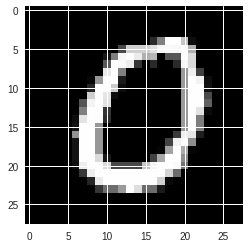

In [21]:
pick_me = np.random.randint(len(test_data))
show_image(test_data[pick_me])

## Convolution and Pooling Layers

In [0]:
def conv_layer(incoming, num_kernels, kernel_sz, 
               strides=[1, 1, 1, 1], padding='SAME',
               bval=0.01, 
               activation_fn=tf.nn.relu, 
               name=None):
    prev_outshape = incoming.shape.dims[-1].value
    kshape = kernel_sz + [prev_outshape, num_kernels]

    fan_in = np.prod(incoming.shape[1:]).value
    xavier_stddev = np.sqrt(2.0 / fan_in)
    
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(tf.truncated_normal(kshape, stddev=xavier_stddev), name='kernel')
        b = tf.Variable(tf.constant(bval, shape=[num_kernels]), name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        return z if activation_fn is None else activation_fn(z)

In [0]:
def pool_layer(incoming, ksize, strides=None, padding='VALID',
               pool_fn=tf.nn.max_pool, name=None):
    'create a pooling layer:  we auto-add the leading/trailing 1s'
    ksize = [1] + ksize + [1]
    strides = strides if strides is not None else ksize
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)

In [0]:
def dropout_layer(incoming, keep_prob=None, dropout_fn=tf.nn.dropout, name=None):
  keep_prob = keep_prob if keep_prob is not None else 1.0
  with tf.variable_scope(name, 'dropout_layer'):
    return dropout_fn(incoming, keep_prob)

## LeNet Sub-Networks

As described in the original paper, LeNet has the following layers:

1. Convolution layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(5x5, stride = 1, padding = 2 ('same'))
2. Max Pooling layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2x2, stride = 2)
3. Convolution layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(5x5, stride = 1, padding = 2 ('same'))
4. Max Pooling layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2x2, stride = 2)
5. Fully Connected layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(depth = 120, activation = ReLu)
6. Fully Connected layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(depth =  84, activation = ReLu)
7. Fully Connected layer&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(depth =  10, activation = ReLu)

Define some different architectures.

In [0]:
def not_lenet(images):
    with tf.name_scope('small_model'):
        conv_1 = conv_layer(images, 6, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 16, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])
        
        flat = flatten(pool_2)
        
        fc_layer = fully_connected_sigmoid_layer
        fc_1 = fc_layer(flat, 120)
        fc_2 = fc_layer(fc_1,  84)
        fc_3 = fully_connected_layer(fc_2,  10, w_stddev = 0.5, activation_fn=None)
    
    return fc_3 

In [0]:
def lenet_small(images):
    with tf.name_scope('small_lenet_model'):    
        conv_1 = conv_layer(images, 6, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 16, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])

        flat = flatten(pool_2)

        fc_layer = fully_connected_xavier_relu_layer
        fc_1   = fc_layer(flat, 120)
        fc_2   = fc_layer(fc_1, 84)
        fc_3   = fc_layer(fc_2, 10)
        fc_4   = fully_connected_layer(fc_3, 10, activation_fn=None)
    
    return fc_4

In [0]:
def lenet_big(images):
    with tf.name_scope('big_lenet_model'):    
        conv_1 = conv_layer(images, 32, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 64, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])

        flat = flatten(pool_2)

        fc_layer = fully_connected_xavier_relu_layer
        fc_1   = fc_layer(flat, 400)
        fc_2   = fc_layer(fc_1, 200)
        fc_3   = fc_layer(fc_2, 200)
        fc_4   = fully_connected_layer(fc_3, 10, activation_fn=None)
    
    return fc_4

In [0]:
class MNIST_Model(object):
    def __init__(s):  # non-standard, for abbreviation
        graph = tf.Graph()
        
        with graph.as_default():
            
            with tf.name_scope('inputs'):
                s.x = tf.placeholder(tf.uint8, shape=[None, 28, 28, 1], name="x")
                s.y = tf.placeholder(tf.int32, shape=[None])

            with tf.name_scope('hyperparams'):
                s.learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
            
            with tf.name_scope('preprocess'):
                s.x_cast = tf.cast(s.x, tf.float32)
                s.one_hot_labels = tf.one_hot(s.y, 10)

            with tf.name_scope('model'):
                s.out = lenet_big(s.x_cast)
            
            with tf.name_scope('loss'):
                smce = tf.nn.softmax_cross_entropy_with_logits_v2
                s.loss = tf.reduce_mean(smce(logits=s.out, labels=s.one_hot_labels))
                
            with tf.name_scope('global_step'):
                global_step = tf.Variable(0, trainable=False, name='global_step')
                s.inc_step = tf.assign_add(global_step, 1, name='inc_step')
            
            with tf.name_scope('train'):
                decayed_rate = tf.train.exponential_decay(s.learning_rate,
                                                          global_step,
                                                          600,
                                                          0.998,
                                                          True)
                momopt = tf.train.MomentumOptimizer
                s.train = momopt(decayed_rate, 0.9).minimize(s.loss)

            with tf.name_scope('prediction'):
                s.softmax = tf.nn.softmax(s.out, name="softmax")
                s.prediction = tf.cast(tf.argmax(s.softmax, 1), tf.int32)
                s.pred_correct = tf.equal(s.y, s.prediction)
                s.pred_accuracy = tf.reduce_mean(tf.cast(s.pred_correct, tf.float32)) 
                
            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, 
                                                  s.train], feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds

In [30]:
mm = MNIST_Model()
for epoch in range(15):
    for batch_data, batch_labels in batches(train_data, train_labels, 100):
        train_dict = {mm.x : batch_data, 
                      mm.y : batch_labels,
                      mm.learning_rate : 0.001}
        tr_loss, step, tr_acc = mm.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:8.2f} Acc: {:5.2f}"
    print(info_update.format(epoch, step, tr_loss, tr_acc))

Epoch:  0 Step:   600 Loss:     0.02 Acc:  0.99
Epoch:  1 Step:  1200 Loss:     0.06 Acc:  0.98
Epoch:  2 Step:  1800 Loss:     0.02 Acc:  0.99
Epoch:  3 Step:  2400 Loss:     0.01 Acc:  1.00
Epoch:  4 Step:  3000 Loss:     0.04 Acc:  0.98
Epoch:  5 Step:  3600 Loss:     0.00 Acc:  1.00
Epoch:  6 Step:  4200 Loss:     0.04 Acc:  0.99
Epoch:  7 Step:  4800 Loss:     0.02 Acc:  0.98
Epoch:  8 Step:  5400 Loss:     0.00 Acc:  1.00
Epoch:  9 Step:  6000 Loss:     0.00 Acc:  1.00
Epoch: 10 Step:  6600 Loss:     0.00 Acc:  1.00
Epoch: 11 Step:  7200 Loss:     0.00 Acc:  1.00
Epoch: 12 Step:  7800 Loss:     0.00 Acc:  1.00
Epoch: 13 Step:  8400 Loss:     0.00 Acc:  1.00
Epoch: 14 Step:  9000 Loss:     0.00 Acc:  1.00


In [31]:
# Get test accuracy
batch_correct_cts = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.x : batch_data,
                 mm.y : batch_labels}
    correctness, curr_preds = mm.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print(sum(batch_correct_cts) / len(test_data))

0.9922


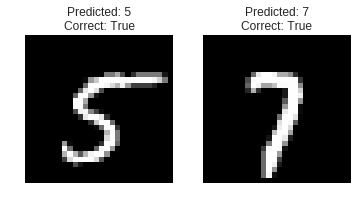

In [32]:
def test_and_show_images(data, labels):
    test_dict = {mm.x : data,
                 mm.y : labels}
    
    correctness, curr_preds = mm.predict(test_dict)
    
    # setup axes
    fig, axes = plt.subplots(nrows=(len(data) // 3) + 1, ncols=3, figsize=(9,len(data)*1.5))
    axes = axes.flat
    for d, lbl, c, p, ax in zip(data, labels, correctness, curr_preds, axes):
        ax.imshow(np.squeeze(d), cmap='Greys_r')
        ax.set_title("Predicted: {}\nCorrect: {}".format(p, bool(c)))
        ax.axis('off')
    for ax in axes: ax.set_visible(False)

indices = [25, 125]
test_and_show_images(test_data[indices], test_labels[indices])

In [0]:
# Get correct and incorrect images
correctness = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.x : batch_data,
                 mm.y : batch_labels}
    curr_correctness, curr_preds = mm.predict(test_dict)
    correctness.extend(curr_correctness)

incorrect = np.where(np.logical_not(np.array(correctness, dtype=np.bool)))[0]

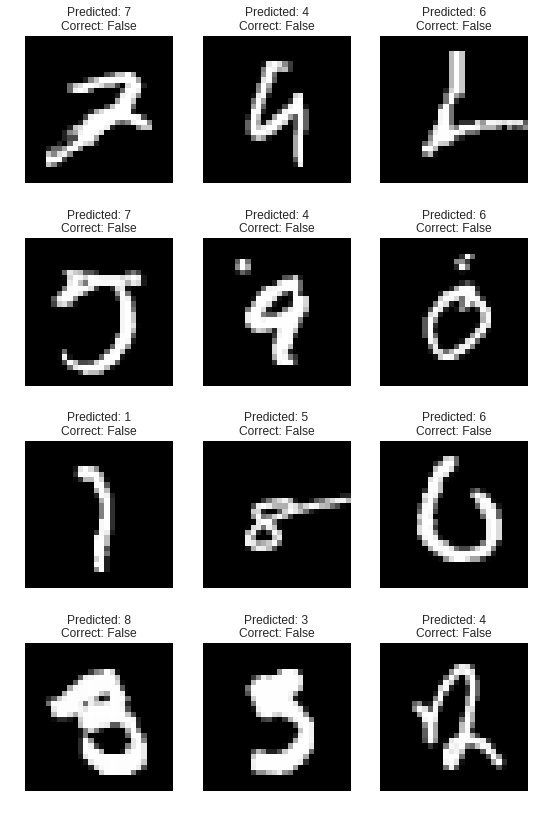

In [34]:
# viewing some incorrect images
indices = incorrect[:12]
test_and_show_images(test_data[indices], test_labels[indices])

## CIFAR-10

In [35]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [0]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

In [37]:
print('Shape of training data:', x_train.shape)
print('Shape of test data:', x_test.shape)

Shape of training data: (50000, 32, 32, 3)
Shape of test data: (10000, 32, 32, 3)


7


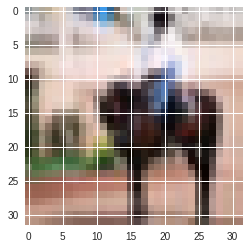

In [39]:
plt.imshow(x_train[11])
print(y_train[11])

In [0]:
def not_cifar_net(images):
  with tf.name_scope('cifar_model'):
    conv_1 = conv_layer(images, 96, [3, 3])
    conv_2 = conv_layer(conv_1, 96, [3,3], [1, 2, 2,1])
    drop_1 = dropout_layer(conv_2, keep_prob=0.9)
    
    conv_3 = conv_layer(drop_1, 192, [3, 3])
    conv_4 = conv_layer(conv_3, 192, [3, 3], [1, 2, 2, 1])
    drop_2 = dropout_layer(conv_4, keep_prob=0.5)

    flat = flatten(drop_2)

    fc_1   = fully_connected_xavier_relu_layer(flat, 256)
    fc_2   = fully_connected_layer(fc_1, 10, activation_fn=None)
    
    return fc_2

In [0]:
class CIFAR_Model(object):
    def __init__(s):  # non-standard, for abbreviation
        graph = tf.Graph()
        
        with graph.as_default():
            
            with tf.name_scope('inputs'):
                s.x = tf.placeholder(tf.uint8, shape=[None, 32, 32, 3], name="x")
                s.y = tf.placeholder(tf.int32, shape=[None])

            with tf.name_scope('hyperparams'):
                s.learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
            
            with tf.name_scope('preprocess'):
                s.x_cast = tf.cast(s.x, tf.float32)
                s.one_hot_labels = tf.one_hot(s.y, 10)

            with tf.name_scope('model'):
                s.out = not_cifar_net(s.x_cast)
            
            with tf.name_scope('loss'):
                smce = tf.nn.softmax_cross_entropy_with_logits_v2
                s.loss = tf.reduce_mean(smce(logits=s.out, labels=s.one_hot_labels))
                
            with tf.name_scope('global_step'):
                global_step = tf.Variable(0, trainable=False, name='global_step')
                s.inc_step = tf.assign_add(global_step, 1, name='inc_step')
            
            with tf.name_scope('train'):
                decayed_rate = tf.train.exponential_decay(s.learning_rate,
                                                          global_step,
                                                          600,
                                                          0.998,
                                                          True)
                momopt = tf.train.MomentumOptimizer
                s.train = momopt(decayed_rate, 0.9).minimize(s.loss)

            with tf.name_scope('prediction'):
                s.softmax = tf.nn.softmax(s.out, name="softmax")
                s.prediction = tf.cast(tf.argmax(s.softmax, 1), tf.int32)
                s.pred_correct = tf.equal(s.y, s.prediction)
                s.pred_accuracy = tf.reduce_mean(tf.cast(s.pred_correct, tf.float32)) 
                
            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, 
                                                  s.train], feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds

In [43]:
cf = CIFAR_Model()
for epoch in range(20):
    for batch_data, batch_labels in batches(x_train, y_train, 100):
        train_dict = {cf.x : batch_data, 
                      cf.y : batch_labels,
                      cf.learning_rate : 0.001}
        tr_loss, step, tr_acc = cf.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:8.2f} Acc: {:5.2f}"
    print(info_update.format(epoch, step, tr_loss, tr_acc))

Epoch:  0 Step:   500 Loss:     1.77 Acc:  0.41
Epoch:  1 Step:  1000 Loss:     1.46 Acc:  0.42
Epoch:  2 Step:  1500 Loss:     1.44 Acc:  0.54
Epoch:  3 Step:  2000 Loss:     1.30 Acc:  0.45
Epoch:  4 Step:  2500 Loss:     0.98 Acc:  0.67
Epoch:  5 Step:  3000 Loss:     1.18 Acc:  0.63
Epoch:  6 Step:  3500 Loss:     1.02 Acc:  0.65
Epoch:  7 Step:  4000 Loss:     0.57 Acc:  0.81
Epoch:  8 Step:  4500 Loss:     0.69 Acc:  0.78
Epoch:  9 Step:  5000 Loss:     0.72 Acc:  0.76
Epoch: 10 Step:  5500 Loss:     0.70 Acc:  0.78
Epoch: 11 Step:  6000 Loss:     0.74 Acc:  0.72
Epoch: 12 Step:  6500 Loss:     0.53 Acc:  0.81
Epoch: 13 Step:  7000 Loss:     0.73 Acc:  0.72
Epoch: 14 Step:  7500 Loss:     0.76 Acc:  0.76
Epoch: 15 Step:  8000 Loss:     0.51 Acc:  0.83
Epoch: 16 Step:  8500 Loss:     0.47 Acc:  0.83
Epoch: 17 Step:  9000 Loss:     0.54 Acc:  0.80
Epoch: 18 Step:  9500 Loss:     0.29 Acc:  0.90
Epoch: 19 Step: 10000 Loss:     0.30 Acc:  0.91


In [44]:
# Get test accuracy
batch_correct_cts = []
for batch_data, batch_labels in batches(x_test, y_test, 200):
    test_dict = {cf.x : batch_data,
                 cf.y : batch_labels}
    correctness, curr_preds = cf.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print(sum(batch_correct_cts) / len(y_test))

0.7266
